## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# # External features
# train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
# test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
# ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
#            'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
#            'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
# for ft in ext_fts:
#     train[ft] = train_img_ft[ft]
#     test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_enc,sex_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,1,0.021231
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0,0.013766
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0,0.013766
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0,0.013766
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0,0.013766


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766


# Model

In [6]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
# features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


Best: 0.674575 using {'subsample': 0.8383838383838385, 'scale_pos_weight': 1.0, 'reg_lambda': 0.4693877551020408, 'reg_alpha': 0.836734693877551, 'max_depth': 2, 'learning_rate': 0.021458661892110785, 'colsample_bytree': 0.7666666666666666}
0.667163 (0.024293) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.666611 (0.022525) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.667119 (0.024590) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_bytree': 0.53333333

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [9]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.660


,image_name,target,pred
0,ISIC_2637011,0,0.070835
1,ISIC_0015719,0,0.068906
2,ISIC_0052212,0,0.069148
3,ISIC_0068279,0,0.068906
4,ISIC_0074268,0,0.070171


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.017630,0.131603,0.000000,0.000000,0.00000,0.000000,1.000000
pred,33126.0,0.073856,0.010257,0.068161,0.069148,0.07028,0.074883,0.210729


# Feature importance

Fold: 1


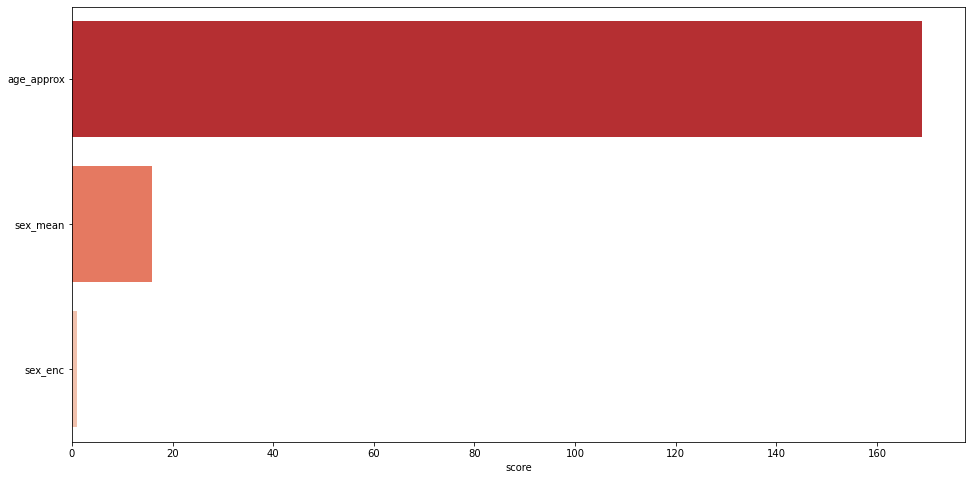

Fold: 2


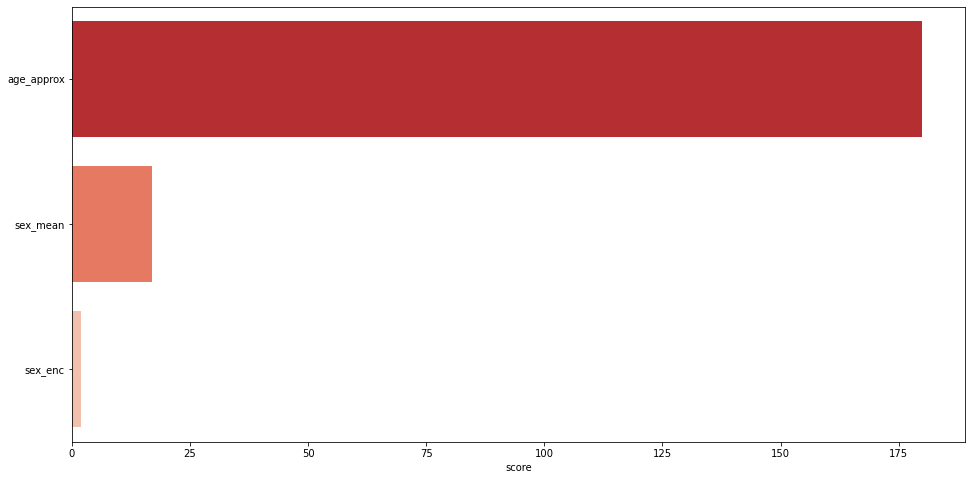

Fold: 3


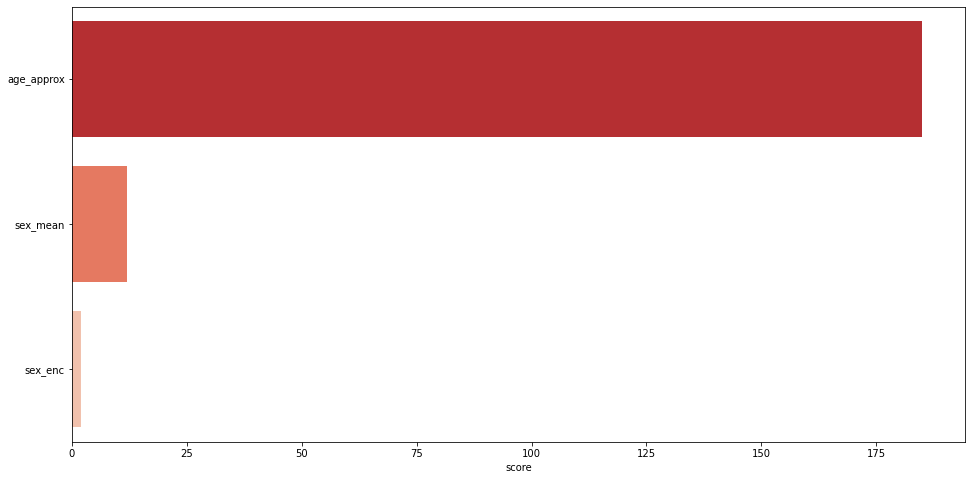

Fold: 4


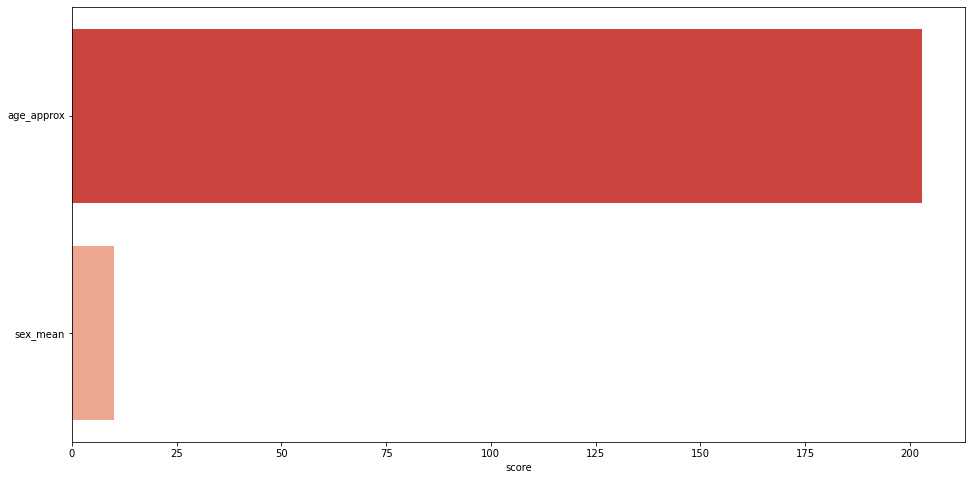

Fold: 5


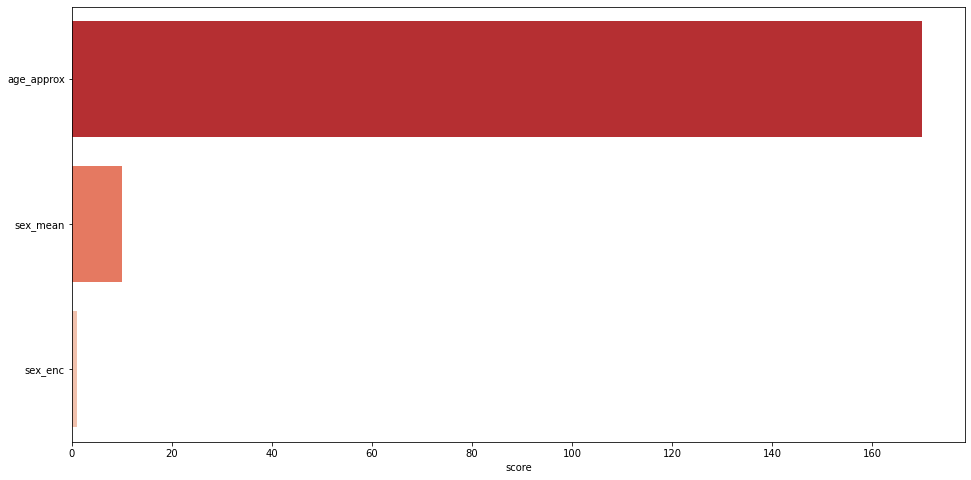

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.680157,0.669856,0.010301,0.673053,0.673663,0.680183,0.678016,0.671552,0.700918,0.696707,0.626076,0.679290,0.670606
Accuracy,0.982228,0.982904,-0.000676,0.982222,0.982927,0.982223,0.982922,0.982211,0.982966,0.982236,0.982875,0.982247,0.982830
Precision,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.680157,0.669856,0.010301,0.673053,0.673663,0.680183,0.678016,0.671552,0.700918,0.696707,0.626076,0.679290,0.670606
male,0.667766,0.657949,0.009817,0.659872,0.674312,0.645809,0.736166,0.676700,0.631648,0.680108,0.631802,0.676340,0.615819
female,0.665852,0.653103,0.012749,0.647510,0.693889,0.685120,0.559347,0.650945,0.747095,0.693480,0.576467,0.652203,0.688717
head/neck,0.756565,0.758904,-0.002338,0.764864,0.710602,0.738632,0.849586,0.765689,0.730974,0.755391,0.773086,0.758251,0.730273
upper extremity,0.690014,0.677416,0.012598,0.672647,0.690571,0.689819,0.687257,0.682577,0.710095,0.713863,0.620823,0.691162,0.678333
lower extremity,0.620200,0.612418,0.007782,0.621372,0.608131,0.626972,0.577856,0.611355,0.662474,0.632770,0.569391,0.608531,0.644238
torso,0.678135,0.667226,0.010909,0.661825,0.701833,0.680095,0.669923,0.672590,0.684748,0.694826,0.629392,0.681337,0.650234
0 <= age < 26,0.602253,0.565089,0.037165,0.609733,0.583051,0.693589,0.176815,0.589861,0.618056,0.538189,0.749852,0.579895,0.697671
26 <= age < 40,0.566615,0.582420,-0.015805,0.554788,0.584457,0.564485,0.647582,0.566858,0.582616,0.586641,0.518657,0.560303,0.578788


# Adversarial Validation

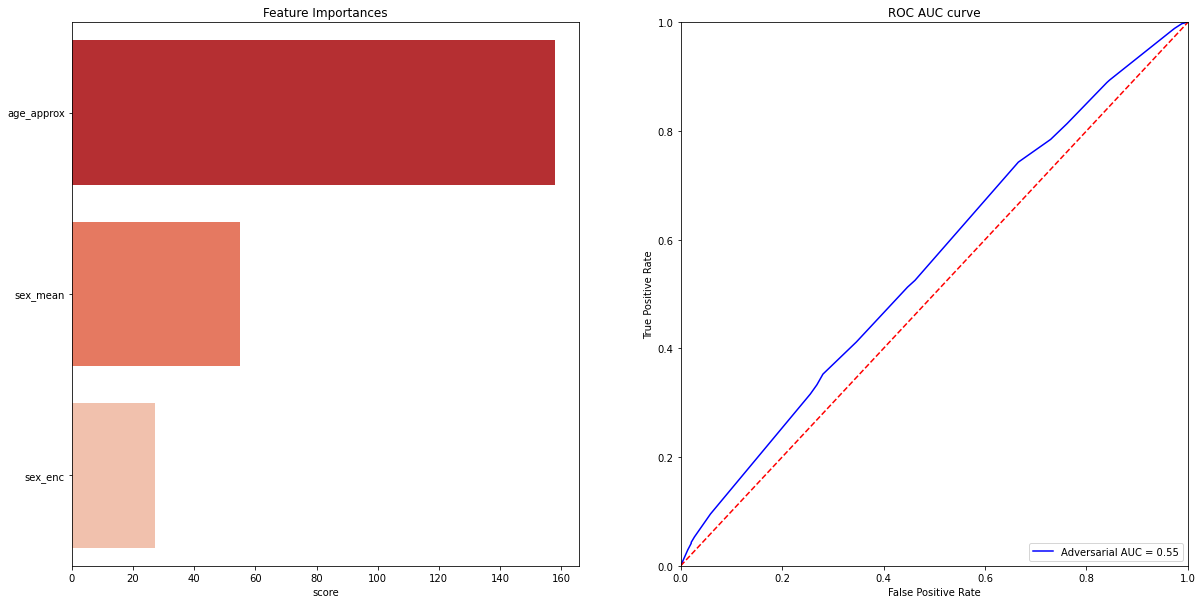

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.070195,0.070835,0.070508,0.070012,0.069420,0.070199
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.068873,0.068906,0.068930,0.068983,0.068399,0.069148
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.068999,0.068906,0.069449,0.068983,0.068510,0.069148
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.068873,0.068906,0.068930,0.068983,0.068399,0.069148
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.070909,0.070171,0.071488,0.069760,0.072844,0.070280
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.068801,0.068906,0.068930,0.068863,0.068161,0.069148
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.070122,0.070835,0.070508,0.069891,0.069180,0.070199
7,ISIC_0075663,female,35.0,torso,unknown,0,0.068801,0.068906,0.068930,0.068863,0.068161,0.069148
8,ISIC_0075914,male,30.0,torso,unknown,0,0.070122,0.070835,0.070508,0.069891,0.069180,0.070199
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.068999,0.068906,0.069449,0.068983,0.068510,0.069148


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.070909,0.070171,0.071488,0.069760,0.072844,0.070280
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.068999,0.068906,0.069449,0.068983,0.068510,0.069148
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.072265,0.072132,0.073120,0.070800,0.073927,0.071347
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.080278,0.078298,0.081795,0.081294,0.082093,0.077910
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.078866,0.076182,0.080383,0.080113,0.080901,0.076752
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.107168,0.110404,0.099743,0.109747,0.107109,0.108837
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.068801,0.068906,0.068930,0.068863,0.068161,0.069148
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.111404,0.117472,0.107981,0.109747,0.107890,0.113931
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.080278,0.078298,0.081795,0.081294,0.082093,0.077910
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.070122,0.070835,0.070508,0.069891,0.069180,0.070199


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.080856,0.078298,0.081795,0.081896,0.083059,0.079233
1,ISIC_0052349,male,40.0,lower extremity,0.070122,0.070835,0.070508,0.069891,0.069180,0.070199
2,ISIC_0058510,female,55.0,torso,0.070909,0.070171,0.071488,0.069760,0.072844,0.070280
3,ISIC_0073313,female,50.0,torso,0.068999,0.068906,0.069449,0.068983,0.068510,0.069148
4,ISIC_0073502,female,45.0,lower extremity,0.068873,0.068906,0.068930,0.068983,0.068399,0.069148
5,ISIC_0074618,male,50.0,lower extremity,0.070323,0.070835,0.071038,0.070012,0.069533,0.070199
6,ISIC_0076801,male,45.0,upper extremity,0.070195,0.070835,0.070508,0.070012,0.069420,0.070199
7,ISIC_0077586,male,50.0,lower extremity,0.070323,0.070835,0.071038,0.070012,0.069533,0.070199
8,ISIC_0082004,female,45.0,torso,0.068873,0.068906,0.068930,0.068983,0.068399,0.069148
9,ISIC_0082785,male,65.0,lower extremity,0.080278,0.078298,0.081795,0.081294,0.082093,0.077910


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

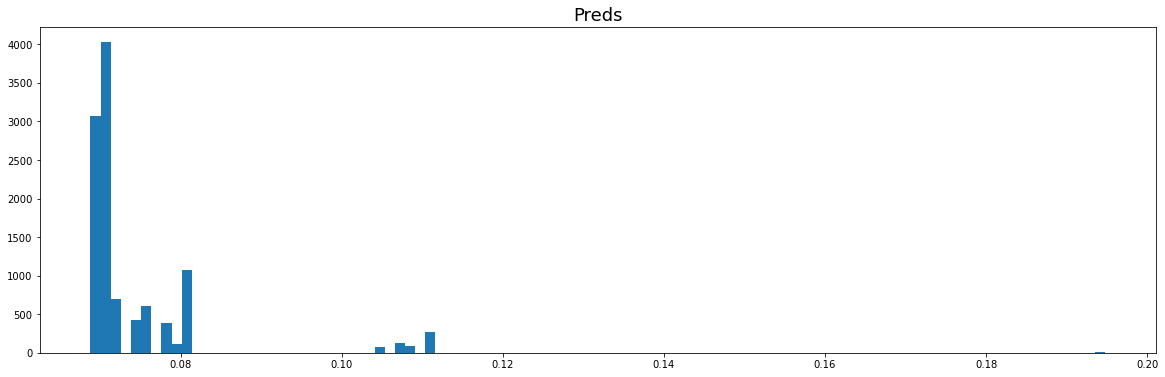

,image_name,target
0,ISIC_0052060,0.080856
1,ISIC_0052349,0.070122
2,ISIC_0058510,0.070909
3,ISIC_0073313,0.068999
4,ISIC_0073502,0.068873
5,ISIC_0074618,0.070323
6,ISIC_0076801,0.070195
7,ISIC_0077586,0.070323
8,ISIC_0082004,0.068873
9,ISIC_0082785,0.080278


,target
count,10982.000000
mean,0.074078
std,0.010042
min,0.068801
25%,0.068999
50%,0.070195
75%,0.076255
max,0.194763


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)